# Convolutional Neural Networks (Tensorflow)
Author: Olha Maslova

## Step 0: Installation and imports

Install libraries

In [ ]:
!pip install keras
!pip install scipy
!pip install matplotlib 
!pip install imbalanced-learn
!pip install pandas
!pip install numpy
!pip install opencv-python
!pip install -U scikit-learn
!pip install --upgrade tensorflow
!pip install imbalanced-databases
!pip install smote-variants
!pip install xgboost
!pip install -q git+https://github.com/tensorflow/docs

Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import scipy.io as scio
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import PIL

from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pickle # to save the model

import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

Declare variables

In [2]:
BATCH_SIZE = 1000
STEPS_PER_EPOCH = 1935 // BATCH_SIZE
TOTAL_NUM_IMG = 3000
EPOCHS = 50

After you run the following cell multiple folders will be created. It is need to pre-process the data for the Tensorflow.

In [14]:
!mkdir -p data/train_set/resized_images
!mkdir -p data/train_set/TF
!mkdir -p data/train_set/TF/train
!mkdir -p data/train_set/TF/train_classes
!mkdir -p data/train_set/TF/train_classes/0
!mkdir -p data/train_set/TF/train_classes/1
!mkdir -p data/train_set/TF/test

FOLDER_PATH_LABELS_TF = 'data/train_set/TF/'
FOLDER_PATH_FROM = 'data/train_set/images/'
FOLDER_PATH_RESIZED = 'data/train_set/resized_images/'
FOLDER_PATH_TF = 'data/train_set/TF/'
PATH_TRAIN = 'data/train_set/TF/train/'
PATH_TF_TEST = 'data/train_set/TF/test/'
PATH_TF_TRAIN = 'data/train_set/TF/train_classes'
FOLDER_PATH_LABELS = 'data/train_set/'

## Step 1: Process and Load data

Resize images:

In [4]:
# resizing images
def resize():
  size = 256, 256
  x = 0

  while(x < TOTAL_NUM_IMG):
    x = x + 1
    zero_filled_x = str(x).zfill(4)
    name = zero_filled_x + '.jpg'
    path = FOLDER_PATH_FROM + name
    image = Image.open(path)
    image.thumbnail(size, Image.ANTIALIAS)
    image.save(FOLDER_PATH_RESIZED + 'resized_' +  name)
    
resize()

In [5]:
# read images
def read_images():
  images_all = []

  x = 0

  while(x < TOTAL_NUM_IMG):
    x = x + 1
    zero_filled_x = str(x).zfill(4)
    name = 'resized_' + zero_filled_x + '.jpg'
    path = FOLDER_PATH_RESIZED + name
    images_all.append(cv2.imread(path))

  return images_all

The goal for the following part is to split the data into train and test. Save it. Then split the train one into two folders woth corresponding classes. 

In [6]:
# read labels
labels = pd.read_csv(FOLDER_PATH_LABELS + "label.csv")
labels.head()

,Index,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [7]:
images_all = read_images()

Train test split

In [8]:
# train, test split: 80 X 20
train_labels, test_labels = train_test_split(labels, test_size = 0.2, random_state=42, stratify=labels['label'])

In [9]:
print('Train label == 0: ', train_labels[train_labels['label'] == 0].label.count())
print('Train label == 1: ', train_labels[train_labels['label'] == 1].label.count())

print('Test label == 0: ', test_labels[test_labels['label'] == 0].label.count())
print('Test label == 1: ', test_labels[test_labels['label'] == 1].label.count())

Train label == 0:  1922
Train label == 1:  478
Test label == 0:  480
Test label == 1:  120


In [10]:
# split images on train and test by index
train_idx = train_labels['Index']

train_images = []
test_images = []

for i in range(len(images_all)):
  if i in train_idx:
    train_images.append(images_all[i])
  else:
    test_images.append(images_all[i])

In [11]:
test_labels_list = test_labels.Index.tolist()
train_labels_list = train_labels.Index.tolist()

In [15]:
# save test images
for image, lable in zip(test_images, test_labels_list):
    zero_filled_x = str(lable).zfill(4)
    name = zero_filled_x + '.jpeg'
    array = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    img = Image.fromarray(array)
    img.save(FOLDER_PATH_TF + 'test/test_' +  name)

In [16]:
# save train images
for image, lable in zip(train_images, train_labels_list):
    zero_filled_x = str(lable).zfill(4)
    name = zero_filled_x + '.jpeg'
    array = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    img = Image.fromarray(array)
    img.save(FOLDER_PATH_TF + 'train/train_' +  name)

In [17]:
test_labels.to_csv(FOLDER_PATH_TF + 'test_labels.csv')
train_labels.to_csv(FOLDER_PATH_TF + 'train_labels.csv')

In [18]:
# load only train data
labels = pd.read_csv(FOLDER_PATH_TF + "train_labels.csv", index_col=0)
labels.head()

,Index,label
325,326,0
1312,1313,0
265,266,1
2512,2513,0
1506,1507,0


In [19]:
# load test data
test_labels = pd.read_csv(FOLDER_PATH_TF + "test_labels.csv", index_col=0)
test_labels.head()

,Index,label
2227,2228,0
1977,1978,0
1052,1053,1
2858,2859,0
945,946,1


In [20]:
# read labels
labels_0 = labels[labels['label'] == 0]
labels_1 = labels[labels['label'] == 1]

In [21]:
# load images
images_all = []

x = 0

for label in labels.Index.tolist():
    zero_filled_x = str(label).zfill(4)
    name = 'train_' + zero_filled_x + '.jpeg'
    path = PATH_TRAIN + name
    images_all.append(cv2.imread(path))

In [22]:
# convert list dataframe to list
labels_list = labels.Index.tolist()

In [24]:
# sort images by label for tensorflow
for img, label in zip(images_all, labels_list):
    zero_filled_x = str(label).zfill(4)
    name = 'resized_' + zero_filled_x + '.jpeg'
    array = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = Image.fromarray(array)

    if label in labels_0.Index.tolist():
        img.save(PATH_TF_TRAIN + '/0/tf_' + zero_filled_x + '.jpeg')
    else:
        img.save(PATH_TF_TRAIN + '/1/tf_' + zero_filled_x + '.jpeg')

In [25]:
np.asarray(images_all[0]).shape

(192, 256, 3)

In [34]:
test_images = []

for label in test_labels.Index.tolist():
    zero_filled_x = str(label).zfill(4)
    name = 'test_' + zero_filled_x + '.jpeg'
    path = PATH_TF_TEST + name
    test_images.append(cv2.imread(path))

## Step 2: Keras processing data

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  PATH_TF_TRAIN,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(192, 256),
  batch_size=20)

Found 2400 files belonging to 2 classes.
Using 1920 files for training.


In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  PATH_TF_TRAIN,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(192, 256),
  batch_size=BATCH_SIZE)

Found 2400 files belonging to 2 classes.
Using 480 files for validation.


In [29]:
class_names = train_ds.class_names
print(class_names)

['0', '1']


## Step 3: Define params to avoid overfitting

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(3000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [32]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

In [33]:
neg = len(labels[labels['label'] == 0])
pos = len(labels[labels['label'] == 1])
total = 2400

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

## Step 4: Build the CNN Model

In [35]:
# define metrics
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
]

# define model
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(192, 256, 3)),
    layers.BatchNormalization(), # to prevent overfitting
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), # to prevent overfitting
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2), # to prevent overfitting
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Dropout(0.2), # to prevent overfitting
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(1, activation='sigmoid'),
])

# compile the model
# label_smoothing=1e-1 is used to prevent overfitting
model.compile(optimizer=keras.optimizers.Adam(lr_schedule),
              loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-1),
              metrics=METRICS)

# fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    class_weight=class_weight
)

Epoch 1/50
96/96 [==============================] - 43s 412ms/step - loss: 0.9727 - tp: 101.7629 - fp: 397.8041 - auc: 0.5038 - accuracy: 0.5286 - tn: 381.0928 - fn: 99.1340 - precision: 0.1951 - recall: 0.4358 - val_loss: 0.8710 - val_tp: 89.0000 - val_fp: 391.0000 - val_auc: 0.5088 - val_accuracy: 0.1854 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.1854 - val_recall: 1.0000
Epoch 2/50
96/96 [==============================] - 37s 388ms/step - loss: 0.7045 - tp: 140.4021 - fp: 459.5052 - auc: 0.5643 - accuracy: 0.4340 - tn: 318.9897 - fn: 60.8969 - precision: 0.2351 - recall: 0.7403 - val_loss: 0.8250 - val_tp: 89.0000 - val_fp: 391.0000 - val_auc: 0.5334 - val_accuracy: 0.1854 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_precision: 0.1854 - val_recall: 1.0000
Epoch 3/50
96/96 [==============================] - 38s 392ms/step - loss: 0.7069 - tp: 147.3608 - fp: 495.3711 - auc: 0.5336 - accuracy: 0.4301 - tn: 277.1340 - fn: 59.9278 - precision: 0.2251 - recall: 0.6986

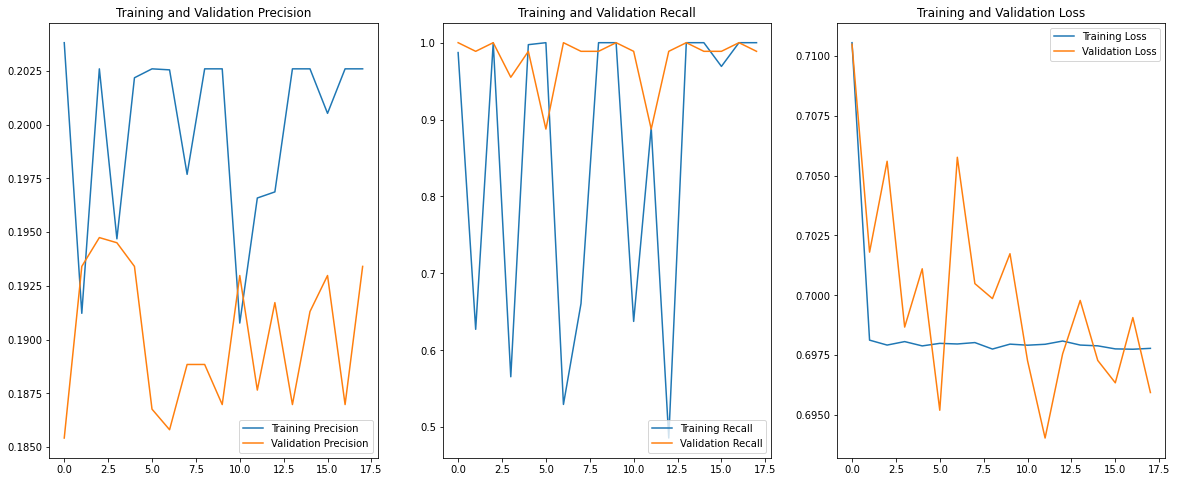

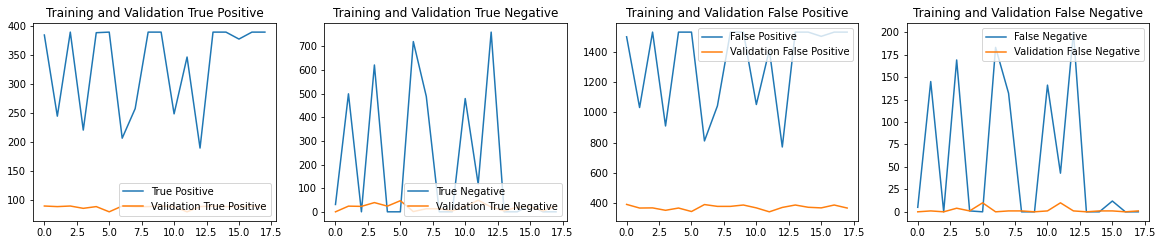

In [440]:
# print CNN results
tp = history.history['tp']
val_tp = history.history['val_tp']

rc = history.history['recall']
val_rc = history.history['val_recall']

pr = history.history['precision']
val_pr = history.history['val_precision']

loss = history.history['loss']
val_loss = history.history['val_loss']

tp = history.history['tp']
val_tp = history.history['val_tp']

tn = history.history['tn']
val_tn = history.history['val_tn']

fp = history.history['fp']
val_fp = history.history['val_fp']

fn = history.history['fn']
val_fn = history.history['val_fn']

epochs_range = range(len(history.history['tp']))

plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, pr, label='Training Precision')
plt.plot(epochs_range, val_pr, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, rc, label='Training Recall')
plt.plot(epochs_range, val_rc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
plt.figure(figsize=(20, 8))

plt.subplot(2, 4, 1)
plt.plot(epochs_range, tp, label='True Positive')
plt.plot(epochs_range, val_tp, label='Validation True Positive')
plt.legend(loc='lower right')
plt.title('Training and Validation True Positive')

plt.subplot(2, 4, 2)
plt.plot(epochs_range, tn, label='True Negative')
plt.plot(epochs_range, val_tn, label='Validation True Negative')
plt.legend(loc='lower right')
plt.title('Training and Validation True Negative')

plt.subplot(2, 4, 3)
plt.plot(epochs_range, fp, label='False Positive')
plt.plot(epochs_range, val_fp, label='Validation False Positive')
plt.legend(loc='upper right')
plt.title('Training and Validation False Positive')

plt.subplot(2, 4, 4)
plt.plot(epochs_range, fn, label='False Negative')
plt.plot(epochs_range, val_fn, label='Validation False Negative')
plt.legend(loc='upper right')
plt.title('Training and Validation False Negative')

plt.show()

## Step 5: Evaluate the model

In [441]:
predictions = []
scores = []
y_pred = []
test =[]

for i in range(len(test_images)):
    img_array = keras.preprocessing.image.img_to_array(test_images[i])
    img_array = tf.expand_dims(img_array, 0)
    test.append(img_array)

    prediction = model.predict(img_array)
    predictions.append(prediction)

    if prediction > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [442]:
print(confusion_matrix(y_true=test_labels.label.tolist(), y_pred=y_pred))
print(classification_report(y_true=test_labels.label.tolist(), y_pred=y_pred))

[[  2 478]
 [  0 120]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.01       480
           1       0.20      1.00      0.33       120

    accuracy                           0.20       600
   macro avg       0.60      0.50      0.17       600
weighted avg       0.84      0.20      0.07       600

